In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib  
sns.set(style="whitegrid")

In [ ]:
DATA_PATH = "../data/raw/synthetic_coffee_health_10000.csv"
df = pd.read_csv(DATA_PATH)

df.fillna({
    'Gender': df['Gender'].mode()[0],
    'Country': df['Country'].mode()[0],
    'Sleep_Quality': df['Sleep_Quality'].mode()[0],
    'Occupation': df['Occupation'].mode()[0],
    'Smoking': df['Smoking'].mode()[0],
    'Alcohol_Consumption': df['Alcohol_Consumption'].mode()[0]
}, inplace=True)

from sklearn.preprocessing import LabelEncoder
categorical_cols = ['Gender', 'Country', 'Sleep_Quality', 'Occupation', 'Smoking', 'Alcohol_Consumption', 'Stress_Level']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

df['BMI_Category'] = pd.cut(df['BMI'], bins=[0,18.5,24.9,29.9,100], labels=['Underweight','Normal','Overweight','Obese'])
df['BMI_Category'] = LabelEncoder().fit_transform(df['BMI_Category'])

df.drop(['ID'], axis=1, inplace=True, errors='ignore')

df = df.dropna(subset=['Health_Issues']).copy()
X = df.drop('Health_Issues', axis=1).replace([np.inf, -np.inf], np.nan).fillna(0)
y = df['Health_Issues']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = joblib.load("../outputs/models/scaler.pkl")
X_test = scaler.transform(X_test)

In [3]:
models = {
    "Final Random Forest": joblib.load("../outputs/models/final_health_risk_model.pkl")
}

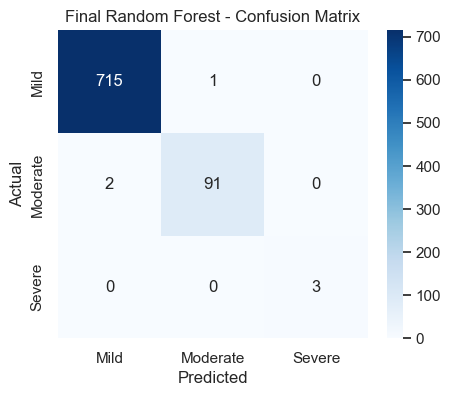

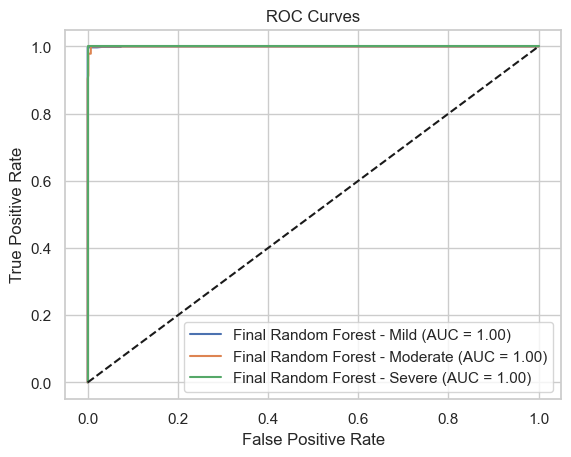

In [ ]:
results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    
    cr = classification_report(y_test, y_pred, output_dict=True)
    
    results[name] = {
        "confusion_matrix": cm,
        "classification_report": cr
    }
    
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f"{name} - Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)
    
    if y_test_bin.shape[1] == 1:  # Binary
        y_score = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test_bin, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    else:  
        y_score = model.predict_proba(X_test)
        for i, class_label in enumerate(lb.classes_):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{name} - {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

In [5]:
rows = []
for name, result in results.items():
    cr = result["classification_report"]
    rows.append({
        "Model": name,
        "Precision": cr["weighted avg"]["precision"],
        "Recall": cr["weighted avg"]["recall"],
        "F1-Score": cr["weighted avg"]["f1-score"],
        "Accuracy": cr["accuracy"],
    })
metrics_df = pd.DataFrame(rows).sort_values(by="F1-Score", ascending=False)
metrics_df

,Model,Precision,Recall,F1-Score,Accuracy
0,Final Random Forest,0.996295,0.996305,0.996297,0.996305
